# Deep Sets Tutorial



**Table of Contents:**


In [1]:
import uproot 
import awkward as ak

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import h5py

**Step 0:** Download the dataset

For this tutorial, we'll be using 



In [2]:
# nMax = int(jdf['n_trks'].max())
# r = (-0.5,nMax+.5)

# for i,l in zip([0,4,5],['l','c','b']):
    
#     mask = (jdf.jet_flav == i)
    
#     plt.hist(jdf.loc[mask,'n_trks'],nMax+1,r,
#              histtype='step',lw=2,label=f'{l}-jets')
    
# plt.xlabel('# of tracks')
# plt.ylabel('Entries')
# plt.xlim(r)
# plt.legend()
# plt.show()

In [3]:
# nbins = 50
# r=(-1,1)

# for i,l in zip([0,4,5],['l','c','b']):
    
#     mask = (jdf.jet_flav == i)
    
    
#     '''
#     To load in the tracks corresponding to this jet flavor,
#     need to pass the df indices for this jet - as shown below
#     '''
#     mask_vals = mask[mask].index

    
#     plt.hist(tdf.loc[mask_vals,'trk_d0'].values.flatten(),
#              nbins,r, histtype='step',lw=2,label=f'{l}-jets')
    
# plt.xlabel('trk_d0')
# plt.ylabel('Entries')
# plt.xlim(r)
# plt.legend()
# plt.show()

**Preprocessing**
- ak.mean
- ak.std

<span style="color:red"> **Question:** </span> What is a good pre-processig for the variables dR + pT_frac ?

**Step 1:** Load in a preprocessed dataset


I think it would be fun to walk through some of the preprocessing shennanigans - but maybe not strictly necessary.

In [4]:
fDir = '../RNNIP/data/mc16d_PFlow_BTagging201903_ttbar_pt_500_d0_3.5_z0_5'

In [5]:
nJets = '3m' #'400k'

jname = f'{fDir}/jet_{nJets}train_25trks_sd0_rev.h5'
tname = f'{fDir}/trk_{nJets}train_25trks_sd0_rev.nc'
dname = f'{fDir}/data_{nJets}train_25trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_ip3d_d0_ip3d_z0_sd0_rev.hdf5'

In [6]:
f = h5py.File(dname,"r")

X_train       = f['X_train'][:]
y_train       = f['y_train'][:]
ix_train      = f['ix_train'][:]
weights_train = f['weights_train'][:]


**Category definitions:** The y vector is the truth label for the jet:
- <span style="color:royalblue"> 0: light-jet </span>. 
- <span style="color:orange"> 1: c-jet </span>.
- <span style="color:limegreen"> 2: b-jet </span>
- <span style="color:crimson"> 3: $\tau$-jet </span> - but we'll remove these from the training set

In [7]:
nClasses = 3 # Only consider l, c, and b-jets

In [8]:
from keras.utils.np_utils import to_categorical

if y_train.max() >= nClasses:

    valid_targets = (y_train < nClasses)

    X_train       = X_train[valid_targets]
    y_train       = y_train[valid_targets]
    ix_train      = ix_train[valid_targets]
    weights_train = weights_train[valid_targets]

    y_train_cat = to_categorical(y_train, num_classes=nClasses)

In [9]:
X_train.shape

(2865138, 25, 15)

**Step 2:** Set up a Deep Sets architecture

In [10]:
import os

from keras.layers import BatchNormalization, Layer, TimeDistributed, Dropout
from keras.layers import Dense, Input, ReLU, Masking, LSTM
from keras.models import Model
#from keras.optimizers import Adam

from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras import backend as K
#from plottingFunctions import sigBkgEff

# Some magic so that the notebook will reload external python modules
%load_ext autoreload
%autoreload 2

 For the most part, Keras is very modular and lets you stack the common layers that you care just like legos to build a custom architecture, and these are the layers that are loaded above.For the Deep-Sets model, we just needed a custom layer to implement this sum over tracks. The only custom layer that we needed was a Sum layer, which is in the block below.

In [75]:
# Store the dimensions of the input dataset for setting up the model
nJets, maxNumTrks, nFeatures = X_train.shape

**Set up the model skeleton** 

The model parameters are set as variables to be easy to train in the tutorial.

- ppm_sizes_int: A list defining the size for each of the dense layers of the per particle network Φ
- dense_sizes_int: A list defining the size for each of the dense layers of the per particle network F

In [12]:
class Sum(Layer):
    """
    Simple sum layer.
    The tricky bits are getting masking to work properly, but given
    that time distributed dense layers _should_ compute masking on their
    own.

    Author: Dan Guest
    https://github.com/dguest/flow-network/blob/master/SumLayer.py

    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True

    def build(self, input_shape):
        pass

    def call(self, x, mask=None):
        if mask is not None:
            x = x * K.cast(mask, K.dtype(x))[:,:,None]
        return K.sum(x, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[2]

    def compute_mask(self, inputs, mask):
        return None

**TO DO:** Include a picture of an architecture and _ask_ them to implement it!

In [13]:
ppm_sizes_int = [50,50,25]
dense_sizes_int = [50,50]

In [14]:
trk_inputs = Input(shape=(maxNumTrks,nFeatures))
masked_inputs = Masking(mask_value=0)(trk_inputs)
tdd = masked_inputs

for i, phi_nodes in enumerate(ppm_sizes_int):

    tdd = TimeDistributed(Dense(phi_nodes,activation='linear'),name="Phi{}_Dense".format(i))(tdd)
    tdd = TimeDistributed(ReLU(),name="Phi{}_ReLU".format(i))(tdd)

# This is where the magic happens... sum up the track features!
F = Sum(name="Sum")(tdd)

for j, F_nodes in enumerate(dense_sizes_int):

    F = Dense(F_nodes, activation='linear', name="F{}_Dense".format(j))(F)
    F = ReLU(name="F{}_ReLU".format(j))(F)

output = Dense(nClasses, activation='softmax',name="Jet_class")(F)
dips = Model(inputs=trk_inputs, outputs=output)

As a sanitry check, you can check the structure of the model.

In [15]:
dips.summary() 

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25, 15)]          0         
_________________________________________________________________
masking (Masking)            (None, 25, 15)            0         
_________________________________________________________________
Phi0_Dense (TimeDistributed) (None, 25, 50)            800       
_________________________________________________________________
Phi0_ReLU (TimeDistributed)  (None, 25, 50)            0         
_________________________________________________________________
Phi1_Dense (TimeDistributed) (None, 25, 50)            2550      
_________________________________________________________________
Phi1_ReLU (TimeDistributed)  (None, 25, 50)            0         
_________________________________________________________________
Phi2_Dense (TimeDistributed) (None, 25, 25)            1275  

To train the model, you need to define what you mean by a model performing better or worse, which we quantify by a loss function. For multi-class classification, we use the categorical cross-entropy, which maximizes the node corresponding to the true label of the jet.You also need a strategy for updating the weights as you minimize the loss, which is inside the optimizer. There are many different optimization strategies on the market and available in Keras, but the optimizer adam is often a good one to start with since it provides a way to decrease the weight update as you converge onto a solution.This is what is done in the "compile" function below.

In [16]:
dips.compile(loss='categorical_crossentropy', optimizer='adam',
             metrics=['acc'])  

**Warm up Q:** _Before training_ the model, what do you think the accuracy will be?


- A.   0% 
- B.   33%
- C.   50%
- D.   100%

**Test your answer above:** 

In [17]:
dips.evaluate(X_train,y_train_cat,batch_size=128)

22384/22384 [==============================] - 42s 2ms/step - loss: 2.0770 - acc: 0.3611


[2.076963424682617, 0.3610635995864868]

The second number above is the accuracy, which is close to 1/3, since before training the model is just guessing among the three outputs.The first number is the loss, which gets minimized in the training.

**Training details**

When training a model, how do you decide how long to go for? When training NNs, you look at your training dataset multiple times as you converge to a solution. A single pass over the training dataset is called an epoch.

The model nEpochs is set at 5 right now and is a variable for the maximimum number of epochs, but in practice, it's common to set this value to something larger, and use the loss on a separate validation dataset to decide when to stop training. This is set up in the EarlyStopping callback which says to stop training when the loss on the validation dataset (val_loss) has not improved in 10 epochs.

Then the ModelCheckpoint below saves the name for the model weights file you're using.

In [18]:
nEpochs = 5

earlyStop = EarlyStopping(monitor='val_loss', verbose=True, patience=10)

dips_mChkPt = ModelCheckpoint('dips_weights.h5',
                              monitor='val_loss', 
                              verbose=True,
                              save_best_only=True,
                              save_weights_only=True)

In [19]:
nTrain = int(5e5)

In [20]:
dips_hist = dips.fit(X_train[:nTrain], y_train_cat[:nTrain], epochs=nEpochs, 
                     batch_size=128,validation_split=0.2,
                     callbacks=[earlyStop, dips_mChkPt])

Epoch 1/5
3125/3125 [==============================] - 9s 3ms/step - loss: 0.4978 - acc: 0.8288 - val_loss: 0.4696 - val_acc: 0.8376

Epoch 00001: val_loss improved from inf to 0.46955, saving model to dips_weights.h5
Epoch 2/5
3125/3125 [==============================] - 9s 3ms/step - loss: 0.4660 - acc: 0.8383 - val_loss: 0.4599 - val_acc: 0.8400

Epoch 00002: val_loss improved from 0.46955 to 0.45988, saving model to dips_weights.h5
Epoch 3/5
3125/3125 [==============================] - 9s 3ms/step - loss: 0.4591 - acc: 0.8406 - val_loss: 0.4558 - val_acc: 0.8418

Epoch 00003: val_loss improved from 0.45988 to 0.45578, saving model to dips_weights.h5
Epoch 4/5
3125/3125 [==============================] - 9s 3ms/step - loss: 0.4555 - acc: 0.8417 - val_loss: 0.4545 - val_acc: 0.8424

Epoch 00004: val_loss improved from 0.45578 to 0.45448, saving model to dips_weights.h5
Epoch 5/5
3125/3125 [==============================] - 9s 3ms/step - loss: 0.4528 - acc: 0.8425 - val_loss: 0.4543 -

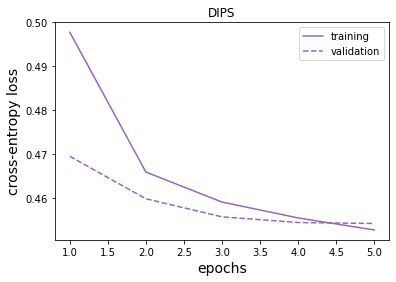

In [35]:
epochs = np.arange(1,len(dips_hist.history['loss'])+1)

plt.plot(epochs,dips_hist.history['loss'],color='C4',label='training')
plt.plot(epochs,dips_hist.history['val_loss'],color='C4',label='validation',ls='--')
plt.xlabel('epochs',fontsize=14)
plt.ylabel('cross-entropy loss',fontsize=14)
plt.legend()
plt.title('DIPS')

plt.show()

Since we're training w/ only 500k jets, we're overfitting right now, which is why the validation loss is not improving even though the training loss is.

**Evaluate the results with a roc curve**

In [45]:
def sigBkgEff(myModel, X_test, y_test, returnDisc=False, fc=0.07, title=''):

    '''
    Given a model, make the histograms of the model outputs to get the ROC curves.

    Input:
        myModel: A keras model
        X_test: Model inputs of the test set
        y_test: Truth labels for the test set
        returnDisc: If True, also return the raw discriminant 
        fc: The amount by which to weight the c-jet prob in the disc. The
            default value of 0.07 corresponds to the fraction of c-jet bkg
            in ttbar.

    Output:
        effs: A list with 3 entries for the l, c, and b effs
        disc: b-tagging discriminant (will only be returned if returnDisc is True)
    '''

    # Evaluate the performance with the ROC curves!
    predictions = myModel.predict(X_test,verbose=True)

    # To make sure you're not discarding the b-values with high
    # discriminant values that you're good at classifying, use the
    # max from the distribution
    disc = np.log(np.divide(predictions[:,2], fc*predictions[:,1] + (1 - fc) * predictions[:,0]))
    
    '''
    Note: For jets w/o any tracks
    '''
    
    discMax = np.max(disc)
    discMin = np.min(disc)
    
    myRange=(discMin,discMax)
    nBins = 200

    effs = []
    for output, flavor in zip([0,1,2], ['l','c','b']):

        ix = (y_test == output)
        
        # Plot the discriminant output
        nEntries, edges ,_ = plt.hist(disc[ix],alpha=0.5,label='{}-jets'.format(flavor),
                                      bins=nBins, range=myRange, density=True, log=True)
        
        #nEntries, edges = np.histogram(disc[ix], nBins, myRange, density=True)

        '''
        nEntries is just a sum of the weight of each bin in the histogram.
        
        Since high Db scores correspond to more b-like jets, compute the cummulative density function
        from summing from high to low values, this is why we reverse the order of the bins in nEntries
        using the "::-1" numpy indexing.
        '''
        eff = np.add.accumulate(nEntries[::-1]) / np.sum(nEntries)
        effs.append(eff)

    plt.title(title)
    plt.legend()
    plt.xlabel('$D = \ln [ p_b / (f_c p_c + (1- f_c)p_l ) ]$',fontsize=14)
    plt.ylabel('Normalized entries')
        
    if returnDisc:
        return effs, disc
    else:
        return effs


In [23]:
# To draw the roc curves faster, look at a subset of the test dataset. 
nTest = 1000000

X_test = f['X_train'][:]
y_test = f['y_train'][:]

31250/31250 [==============================] - 23s 738us/step


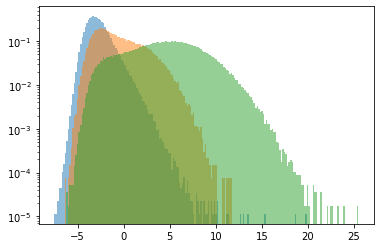

In [24]:
(leff, ceff, beff), d = sigBkgEff(dips, X_test[:nTest], y_test[:nTest], returnDisc=True)

<ipython-input-28-12c6d3f92fbe>:3: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(beff, 1 / leff, color='C4', label='dips: l-rej')
<ipython-input-28-12c6d3f92fbe>:6: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(beff, 1 / ceff, color='C4', linestyle='--', label='dips: c-rej')
<ipython-input-28-12c6d3f92fbe>:14: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,int(2e3))


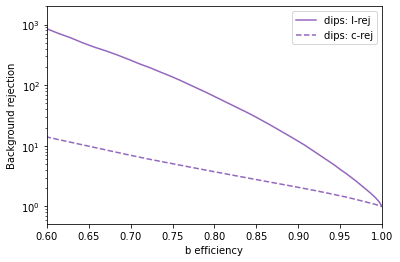

In [28]:
# l-rej
plt.figure()
plt.plot(beff, 1 / leff, color='C4', label='dips: l-rej')

# c-rej
plt.plot(beff, 1 / ceff, color='C4', linestyle='--', label='dips: c-rej')
plt.xlabel('b efficiency')
plt.ylabel('Background rejection')

plt.legend()
#plt.title(title)
plt.yscale("log")
plt.xlim(0.6,1)
plt.ylim(0,int(2e3))

plt.show()

**Step 3:** Test out batch norm


- batch_norm: Whether or not to use BatchNormalization, a regularization tecnique for deep models. The key idea is that it's easier for models to train if the input are bell shaped and centered around 0 to take advantage of the non-linearity. This is why we normalize the inputs in the pre-processing, and the Batch-Normalization is a technique which normalized the outputs from a network layer so that the next layer has nicely scaled inputs for the training. 

**Step 4:** Test out other permutation invariant operations

- max
- mean

In [30]:
class Max(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True

    def build(self, input_shape):
        pass

    def call(self, x, mask=None):
        if mask is not None:
            x = x * K.cast(mask, K.dtype(x))[:,:,None]
        return K.max(x, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[2]

    def compute_mask(self, inputs, mask):
        return None

In [31]:
class Mean(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True

    def build(self, input_shape):
        pass

    def call(self, x, mask=None):
        if mask is not None:
            x = x * K.cast(mask, K.dtype(x))[:,:,None]
        return K.mean(x, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[2]

    def compute_mask(self, inputs, mask):
        return None

In [33]:
trk_inputs = Input(shape=(maxNumTrks,nFeatures))
masked_inputs = Masking(mask_value=0)(trk_inputs)
tdd = masked_inputs

for i, phi_nodes in enumerate(ppm_sizes_int):

    tdd = TimeDistributed(Dense(phi_nodes,activation='linear'),name="Phi{}_Dense".format(i))(tdd)
    tdd = TimeDistributed(ReLU(),name="Phi{}_ReLU".format(i))(tdd)

# This is where the magic happens... sum up the track features!
F = Max(name="Max")(tdd)

for j, F_nodes in enumerate(dense_sizes_int):

    F = Dense(F_nodes, activation='linear', name="F{}_Dense".format(j))(F)
    F = ReLU(name="F{}_ReLU".format(j))(F)

output = Dense(nClasses, activation='softmax',name="Jet_class")(F)
dips_max = Model(inputs=trk_inputs, outputs=output)

In [37]:
dips_max.compile(loss='categorical_crossentropy', optimizer='adam',
                 metrics=['acc'])  

dips_hist_max = dips_max.fit(X_train[:nTrain], y_train_cat[:nTrain], epochs=nEpochs, 
                         batch_size=128,validation_split=0.2,
                         callbacks=[earlyStop, dips_mChkPt])

Epoch 1/5
3125/3125 [==============================] - 10s 3ms/step - loss: 0.5040 - acc: 0.8267 - val_loss: 0.4823 - val_acc: 0.8334

Epoch 00001: val_loss did not improve from 0.45426
Epoch 2/5
3125/3125 [==============================] - 9s 3ms/step - loss: 0.4754 - acc: 0.8353 - val_loss: 0.4711 - val_acc: 0.8376

Epoch 00002: val_loss did not improve from 0.45426
Epoch 3/5
3125/3125 [==============================] - 9s 3ms/step - loss: 0.4683 - acc: 0.8379 - val_loss: 0.4730 - val_acc: 0.8366

Epoch 00003: val_loss did not improve from 0.45426
Epoch 4/5
3125/3125 [==============================] - 9s 3ms/step - loss: 0.4642 - acc: 0.8389 - val_loss: 0.4649 - val_acc: 0.8387

Epoch 00004: val_loss did not improve from 0.45426
Epoch 5/5
3125/3125 [==============================] - 9s 3ms/step - loss: 0.4619 - acc: 0.8395 - val_loss: 0.4638 - val_acc: 0.8390

Epoch 00005: val_loss did not improve from 0.45426


In [34]:
trk_inputs = Input(shape=(maxNumTrks,nFeatures))
masked_inputs = Masking(mask_value=0)(trk_inputs)
tdd = masked_inputs

for i, phi_nodes in enumerate(ppm_sizes_int):

    tdd = TimeDistributed(Dense(phi_nodes,activation='linear'),name="Phi{}_Dense".format(i))(tdd)
    tdd = TimeDistributed(ReLU(),name="Phi{}_ReLU".format(i))(tdd)

# This is where the magic happens... sum up the track features!
F = Mean(name="Mean")(tdd)

for j, F_nodes in enumerate(dense_sizes_int):

    F = Dense(F_nodes, activation='linear', name="F{}_Dense".format(j))(F)
    F = ReLU(name="F{}_ReLU".format(j))(F)

output = Dense(nClasses, activation='softmax',name="Jet_class")(F)
dips_mean = Model(inputs=trk_inputs, outputs=output)

In [38]:
dips_mean.compile(loss='categorical_crossentropy', optimizer='adam',
                 metrics=['acc'])  

dips_hist_mean = dips_mean.fit(X_train[:nTrain], y_train_cat[:nTrain], epochs=nEpochs, 
                     batch_size=128,validation_split=0.2,
                     callbacks=[earlyStop, dips_mChkPt])

Epoch 1/5
3125/3125 [==============================] - 10s 3ms/step - loss: 0.4955 - acc: 0.8298 - val_loss: 0.4679 - val_acc: 0.8388

Epoch 00001: val_loss did not improve from 0.45426
Epoch 2/5
3125/3125 [==============================] - 9s 3ms/step - loss: 0.4651 - acc: 0.8389 - val_loss: 0.4581 - val_acc: 0.8416

Epoch 00002: val_loss did not improve from 0.45426
Epoch 3/5
3125/3125 [==============================] - 9s 3ms/step - loss: 0.4579 - acc: 0.8409 - val_loss: 0.4554 - val_acc: 0.8420

Epoch 00003: val_loss did not improve from 0.45426
Epoch 4/5
3125/3125 [==============================] - 9s 3ms/step - loss: 0.4543 - acc: 0.8420 - val_loss: 0.4599 - val_acc: 0.8414

Epoch 00004: val_loss did not improve from 0.45426
Epoch 5/5
3125/3125 [==============================] - 9s 3ms/step - loss: 0.4517 - acc: 0.8429 - val_loss: 0.4519 - val_acc: 0.8434

Epoch 00005: val_loss improved from 0.45426 to 0.45194, saving model to dips_weights.h5


**Which of these 3 models is doing the best?** 

Initial check: Compare the loss curves.

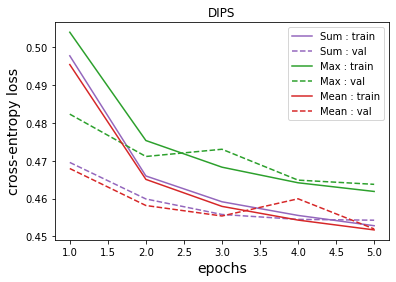

In [39]:
epochs = np.arange(1,len(dips_hist.history['loss'])+1)


for h,c,l in zip([dips_hist,dips_hist_max,dips_hist_mean],['C4','C2','C3'],['Sum','Max','Mean']):
    plt.plot(epochs,h.history['loss'],color=c,label=f'{l} : train')
    plt.plot(epochs,h.history['val_loss'],color=c,label=f'{l} : val',ls='--')
    
plt.xlabel('epochs',fontsize=14)
plt.ylabel('cross-entropy loss',fontsize=14)
plt.legend()
plt.title('DIPS')

plt.show()

Next: Compare the accuracy on the test set?

In [41]:
dips.evaluate(X_train[:nTest],y_train_cat[:nTest],batch_size=128)

7813/7813 [==============================] - 14s 2ms/step - loss: 0.4520 - acc: 0.8427


[0.45199814438819885, 0.842706024646759]

In [42]:
dips_max.evaluate(X_train[:nTest],y_train_cat[:nTest],batch_size=128)

7813/7813 [==============================] - 13s 2ms/step - loss: 0.4610 - acc: 0.8396


[0.4610031247138977, 0.8396340012550354]

In [40]:
dips_mean.evaluate(X_train[:nTest],y_train_cat[:nTest],batch_size=128)

7813/7813 [==============================] - 14s 2ms/step - loss: 0.4498 - acc: 0.8434


[0.44984734058380127, 0.8433510065078735]

Finally, compare the roc curves on the test set?

31250/31250 [==============================] - 23s 741us/step


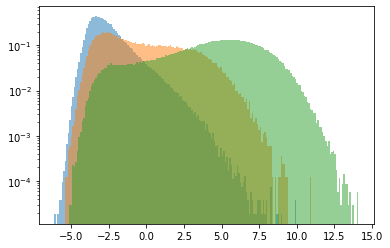

In [43]:
(leff_max, ceff_max, beff_max), d = sigBkgEff(dips_max, X_test[:nTest], y_test[:nTest], returnDisc=True,'Max pooling operation')

31250/31250 [==============================] - 23s 736us/step


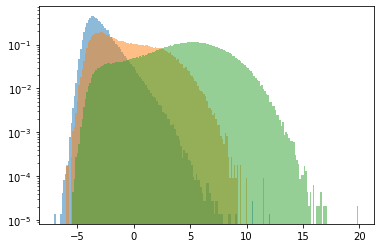

In [44]:
(leff_mean, ceff_mean, beff_mean), d = sigBkgEff(dips_mean, X_test[:nTest], y_test[:nTest], returnDisc=True,'Mean (avg) pooling operation')

<ipython-input-48-0230a8d8f9e9>:7: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(bi, 1 / li, color=c, label=f'{l}: l-rej')
<ipython-input-48-0230a8d8f9e9>:10: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(bi, 1 / ci, color=c, linestyle='--', label=f'{l}: c-rej')
<ipython-input-48-0230a8d8f9e9>:7: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(bi, 1 / li, color=c, label=f'{l}: l-rej')
<ipython-input-48-0230a8d8f9e9>:10: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(bi, 1 / ci, color=c, linestyle='--', label=f'{l}: c-rej')
<ipython-input-48-0230a8d8f9e9>:7: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(bi, 1 / li, color=c, label=f'{l}: l-rej')
<ipython-input-48-0230a8d8f9e9>:10: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(bi, 1 / ci, color=c, linestyle='--', label=f'{l}: c-rej')
<ipython-input-48-0230a8d8f9e9>:18: UserWarning: Attempted to set non-pos

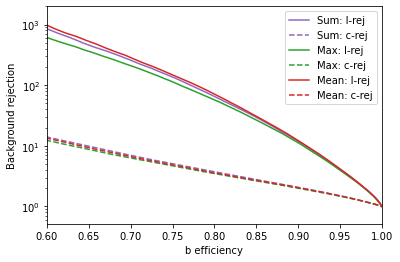

In [48]:
plt.figure()

for bi,li,ci,c, l in zip([beff,beff_max,beff_mean],[leff,leff_max,leff_mean],
                         [ceff,ceff_max,ceff_mean],['C4','C2','C3'],['Sum','Max','Mean']):

    # l-rej
    plt.plot(bi, 1 / li, color=c, label=f'{l}: l-rej')

    # c-rej
    plt.plot(bi, 1 / ci, color=c, linestyle='--', label=f'{l}: c-rej')
plt.xlabel('b efficiency')
plt.ylabel('Background rejection')

plt.legend()
#plt.title(title)
plt.yscale("log")
plt.xlim(0.6,1)
plt.ylim(0,int(2e3))

plt.show()

**Question:**
- Why might this model be doing the best?
- What feature might you be able to add to the `Mean` pooling operation to put physics information back in?

Try adding `ntrks` as a feature to the Mean model and see if the performance is recovered

How to calculate `ntrks`?


Recall, the shape of X_train is (nJets, maxNumTrks, nFeatures) 
and for jets that have fewer than maxNumTrks tracks, the features
for this "blank" track will all be "padded with zeros.


In [ ]:
X_train.shape

Hint: Try using the np.any function to calculate the number of tracks for each jet in X_train

In [88]:
tmask = ~np.all(X_train==0, axis=-1) # False for a padded track

ntrks = np.sum(tmask,axis=1)

In [77]:
ntrks

array([6, 5, 9, ..., 9, 4, 9])

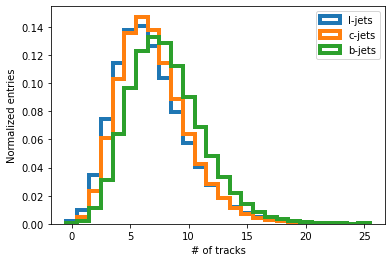

In [78]:
plt.hist(ntrks[y_train==0],26,(-0.5,25.5),histtype='step',lw=4,label='l-jets',density=True)
plt.hist(ntrks[y_train==1],26,(-0.5,25.5),histtype='step',lw=4,label='c-jets',density=True)
plt.hist(ntrks[y_train==2],26,(-0.5,25.5),histtype='step',lw=4,label='b-jets',density=True)

plt.xlabel('# of tracks')
plt.ylabel('Normalized entries')
plt.legend()
plt.show()

In [83]:
ntrks.shape

(2865138,)

In [72]:
X_train.shape

(2865138, 25, 15)

In [90]:
# Broadcast the # of tracks in the jet across the track features
ntrks_broad = np.vstack([ntrks]*maxNumTrks).T

# But need to mask it
ntrks_broad = ntrks_broad * tmask

In [93]:
X_train_exp = np.dstack([X_train, ntrks_broad])

X_train_exp.shape

(2865138, 25, 16)

In [94]:
trk_inputs = Input(shape=(maxNumTrks,nFeatures+1))
masked_inputs = Masking(mask_value=0)(trk_inputs)
tdd = masked_inputs

for i, phi_nodes in enumerate(ppm_sizes_int):

    tdd = TimeDistributed(Dense(phi_nodes,activation='linear'),name="Phi{}_Dense".format(i))(tdd)
    tdd = TimeDistributed(ReLU(),name="Phi{}_ReLU".format(i))(tdd)

# This is where the magic happens... sum up the track features!
F = Mean(name="Mean")(tdd)

for j, F_nodes in enumerate(dense_sizes_int):

    F = Dense(F_nodes, activation='linear', name="F{}_Dense".format(j))(F)
    F = ReLU(name="F{}_ReLU".format(j))(F)

output = Dense(nClasses, activation='softmax',name="Jet_class")(F)
dips_exp = Model(inputs=trk_inputs, outputs=output)

**Step 5 (bonus):** Vizualizations [if time permits]

A fun metric to look at is _saliency maps_